#Arrhythmia

In this analysis, we look at detailed dataset of electrocardiogram readings, and distinguish between the presence or absence of arrhythmia, and classify 
it into one of 16 sub-groups. The dataset and the class descriptions are available at the souce website: [ics.uci.edu](https://archive.ics.uci.edu/ml/datasets/Arrhythmia)

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


**Import Libs**

In [ ]:
from scipy.stats import mode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
%matplotlib inline

**Data contains 452 observations, each with 280 variables.** Most variables are categorical (integer) and continuous (float) variables respectively. The five object variables are examined ahead.Variable names are provided in the source website.

In [ ]:
data  = pd.read_csv('MyDrive/MLData/Arrhythmia/arrhythmia.data',header=None) 
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452 entries, 0 to 451
Columns: 280 entries, 0 to 279
dtypes: float64(120), int64(155), object(5)
memory usage: 988.9+ KB
None


**Check Weight (kg)**

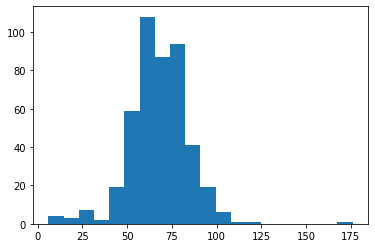

In [ ]:
plt_ = plt.hist(data.iloc[:,3],bins=20)

**Examine the object type variables.**
Columns 10-13 represent vector angles in degrees on front plane of different components of the cardiogram (q, r, s, t, p). And, 14 contains the heart rate.  Some readings contain null values, filled with '?'. This data cannot be included with the null values into ML model.

In [ ]:
data.select_dtypes(include=[object]).iloc[0:5,:]
#Vector angles in degrees on front plane of:, linear
#10 T, 11 P, 12 QRST, 13 J, 14 HRate

,10,11,12,13,14
0,13,64,-2,?,63
1,37,-17,31,?,53
2,34,70,66,23,75
3,11,-5,20,?,71
4,13,61,3,?,?


The heart rate contains null value in only one reading, while the vectors angles collectively are missing 384, a large fraction of 452 total observations. So, the heart rate is included in analysis, while the vector angles are dropped.

In [ ]:
data2 = data.iloc[:,10:15]
null_all = data2[(data2.iloc[:,0]=="?") | (data2.iloc[:,1]=="?") | (data2.iloc[:,2]=="?")|
                 (data2.iloc[:,3]=="?") | (data2.iloc[:,4]=="?") ]
null_hr = data2[(data2.iloc[:,4]=="?") ]
print ("Null Values Total", len(null_all),'\n'
       "Null Values HR   ", len(null_hr))

Null Values Total 384 
Null Values HR    1


**Dropping vector anlgles and a single observation which is missing the heart rate.**

In [ ]:
data3 = data.drop(labels=4, axis=0)
data3 = data3.drop(labels=[10,11,12,13],axis=1)
#Removed Null values in column 10-14
data3.iloc[:,10] = data3.iloc[:,10].astype(int)
#Cast HeartRate data to int

----
**Data Segmentation**

Data is divided into different segments, containing 1) basic 
attributes (height, weight, pulse duration etc) 2) channel measurements
containing readings of identical variables (widths of q, r, s components)
from different channels (DI, DII, DII, AVR etc). 
Each observation contains 280 variables (- dropped vars) from these two categories. For analysis, the basic attributes and one or more of channel measurements are included. We use one or couple of channel data in the analysis; adding every channel, 12 times the data, would make the model 
too complex.  

In [ ]:
include_att = [i for i in range(11)]\
            + [i for i in range(11,23)]\
            + [i for i in range(155,165)]\
            + [i for i in range(23,35)]\
            + [i for i in range(165,175)]
           # + [i for i in range(35,47)]\
           # + [i for i in range(175,185)]
# Primary attributes 0-9, Heart rate 14
# DI: 16-20, deflection 21, ragged/diphasic -27
# DI Amplitude:160-167, QRSA 168,169
#Selection Attributes to use for classification
data_train_x = data3.iloc[:,include_att]
data_train_y = data3.iloc[:,-1]

**Correlations in basic attributes**

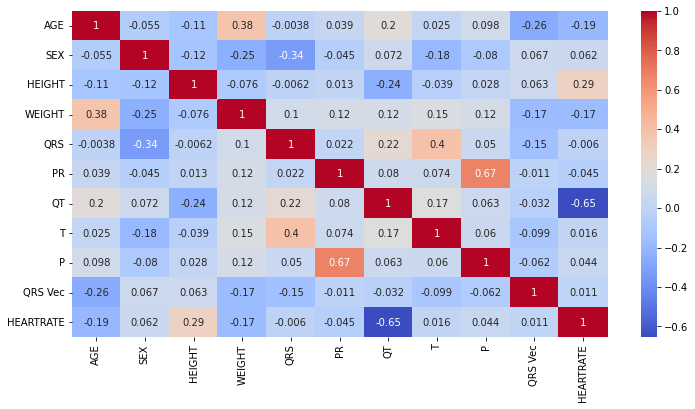

In [ ]:
#Check Correlation in basic attributes
data_corr              = data3.iloc[:,:11]
data_corr.columns      = ["AGE","SEX","HEIGHT","WEIGHT","QRS","PR","QT","T","P","QRS Vec","HEARTRATE"]
corr      = data_corr.corr()
plt_      = plt.figure(figsize=(12,6))
plt_      = sns.heatmap(corr,annot=True,cmap='coolwarm')

Age, weight, heartrate show correlations.

**Unbalanced dataset, which skews towards normal (Class 0) cases.**

Text(0, 0.5, 'Number of Cases')

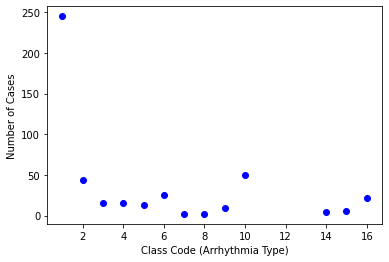

In [ ]:
aa=data_train_y.value_counts()
x_val = aa.index
y_val = aa.values
plt.plot(x_val,y_val,"bo")
plt.xlabel("Class Code (Arrhythmia Type)")
plt.ylabel("Number of Cases")

**Train/Test Split**

In [ ]:
#Split into Train Test
x_train, x_test, y_train, y_test =\
  train_test_split(data_train_x,data_train_y, test_size=0.2, random_state=0)
print(f"Train: {x_train.shape}, {y_train.shape}")
print(f"Test : {x_test.shape}, {y_test.shape}")

Train: (360, 55), (360,)
Test : (91, 55), (91,)


**Using Cross-Validation to estimate the accuracy of various models.**

In [ ]:
#cross-validation score metric
def cv_scoring(classifier,x,y):
    return accuracy_score(y,classifier.predict(x))

#Collection of Models
models = {
    "SVC":SVC(),
    "Gaussian NB":GaussianNB(),
    "Random Forest":RandomForestClassifier(random_state=0),
    "Gradient Boosted":GradientBoostingClassifier(random_state=0),
    "KNN":KNeighborsClassifier(n_neighbors=10, n_jobs=-1),
    "Neural Net":MLPClassifier(hidden_layer_sizes=(100,50,100,50,16))
}

#Train each model, and cross validate (k-fold)
for model in models:
  m_ = models[model]
  sc = cross_val_score(m_, data_train_x, data_train_y, cv = 2,
                       n_jobs = -1,
                       scoring= cv_scoring)
  
  print("--"*10)
  print("{0:20s} {1:} - Avg: {2:5.1f}  ".format(model,sc,np.mean(sc)))

--------------------
SVC                  [0.54424779 0.55111111] - Avg:   0.5  
--------------------
Gaussian NB          [0.11504425 0.21333333] - Avg:   0.2  
--------------------
Random Forest        [0.6460177  0.69333333] - Avg:   0.7  
--------------------
Gradient Boosted     [0.59292035 0.67555556] - Avg:   0.6  
--------------------
KNN                  [0.54867257 0.56888889] - Avg:   0.6  
--------------------
Neural Net           [0.61061947 0.54222222] - Avg:   0.6  


Since Decision Trees perform the best, we test the two DT models with various combination of hyper-parameters. 

**Random Forest Decision Trees**

In [ ]:
class_rf1 = RandomForestClassifier(random_state=0)
class_rf1.fit(x_train,y_train)
class_rf2 = RandomForestClassifier(random_state=0,n_estimators=75)
class_rf2.fit(x_train,y_train)

print("Accuracy RandomForest")
print("Default Params",cv_scoring(class_rf1,x_test,y_test))
print("New Params    ",cv_scoring(class_rf2,x_test,y_test))


Accuracy RandomForest
Default Params 0.6923076923076923
New Params     0.7032967032967034


**Gradient Boosted Decision Trees**

In [ ]:
class_gb1 = GradientBoostingClassifier(random_state=0)
class_gb1.fit(x_train,y_train)
class_gb2 = GradientBoostingClassifier(random_state=0,learning_rate=0.05,
                                       max_features='log2')
class_gb2.fit(x_train,y_train)

print("Accuracy Gradient Boosting Classifier")
print("Default Params",cv_scoring(class_gb1,x_test,y_test))
print("New Params    ",cv_scoring(class_gb2,x_test,y_test))

Accuracy Gradient Boosting Classifier
Default Params 0.6043956043956044
New Params     0.6483516483516484


##Conclusion and Notes
1.  The following parameters were varied, and best performing settings are adopted: n_estimators,criterion, max_depth, max_features. Both randomforest and gradientboosting have these parameters is common, so testing was mostly consistent. 
 
2. In the above, only DI channel is used. DI + DII was tested, but gave worse predictions. More channels can be tested individually or in combination, and  may provide better result. In this analysis, we wanted to test a ML model on data and establish a baseline for what accuracy this models can achieve. **We find best accuracy at 70\% from RandomForest Model.** 